In [1]:
#-----------------------------------------------------------------------
# Solution to the compressible Blasius equation (boundary value problem)
#
# 2 (ρ μ f'')' + f f'' = 0
# (ρ μ h')' + Pr f h' + Pr (γ-1) Ma^2 ρ μ (f'')^2 = 0
#
# where
#    f: Similarity form for the stream function = ψ/√(2 ν_∞ U x)
#    h: Specific enthalpy at the wall
#
# with isothermal bc:
#     f(0)  = f'(0) = 0 
#     f'(∞) = 1
#     h(∞)  = 1
#     h     = θ(0)
#
# following Howarth-Dorodnitsyn transformation 
#     θ     = T / T_∞
#-----------------------------------------------------------------------

In [2]:
using Plots
using Polynomials
using FastGaussQuadrature
using NLsolve
using Interpolations
using LinearAlgebra

In [3]:
default(linewidth=4)
γ = 1.4  # specific heat ratio
Pr = 0.7 # Prandtl number
Ma = 5.0 # Mach number

5.0

In [4]:
η_max = 10.0
N = 30
x_resid = gausslegendre(N-3)[1]
dx_dη = 2 / η_max

UnpackCheb(X) = ChebyshevT(X[1:N]), ChebyshevT(X[N+1:end])

UnpackCheb (generic function with 1 method)

In [5]:
X = zeros(2N-1);

In [6]:
function CompressibleBlasiusResidual(X)
    f, h = UnpackCheb(X)
    f_η = derivative(f, 1) * dx_dη
    f_ηη = derivative(f_η, 1) * dx_dη
    f_ηηη = derivative(f_ηη, 1) * dx_dη
    h_η = derivative(h, 1) * dx_dη
    h_ηη = derivative(h_η, 1) * dx_dη
    blasius = 2 * f_ηηη + f_ηη * f
    blasius_h = h_ηη + Pr * f * h_η + Pr * (γ - 1) * Ma * Ma * f_ηη * f_ηη # enthalpy equation
    R = zeros(2N-1)
    R[1] = f(-1)
    R[2] = f_η(-1)
    R[3] = f_η(1.) - 1
    R[4:N] = blasius.(x_resid)
    R[N+1] = h(-1.) - 2
    R[N+2] = h(1) - 1
    R[N+3:end] = blasius_h.(x_resid)
    R
end

CompressibleBlasiusResidual (generic function with 1 method)

In [49]:
solution = nlsolve(CompressibleBlasiusResidual, X)
f, h = UnpackCheb(solution.zero)
f_η  = derivative(f, 1) * dx_dη
f_ηη = derivative(f_η, 1) * dx_dη;

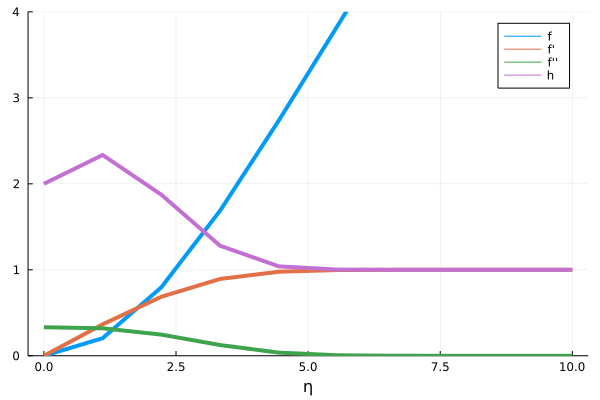

In [35]:
n = 10
x = LinRange(-1, 1, n)
η = (x .+ 1) * η_max / 2
plot(η, [f.(x) f_η.(x) f_ηη.(x) h.(x)], label=["f" "f'" "f''" "h"], ylim=(0, 4))
xlabel!("η")

In [85]:
# Interpolation
function interps(fun, x, η)
     flin = LinearInterpolation(η, fun.(x));
     fquad = extrapolate(scale(interpolate(fun.(x), 
                                           BSpline(Quadratic(Line(OnGrid())))
                                          ),
                               η
                              ),
                         Throw()
                        );
     fspline = CubicSplineInterpolation(η, fun.(x));
     return flin, fquad, fspline
end

u_lin, u_quad, u_spline = interps(f_η, x, η); # u = U * f_η
T_lin, T_quad, T_spline = interps(h, x, η);   # T = T_∞ * h

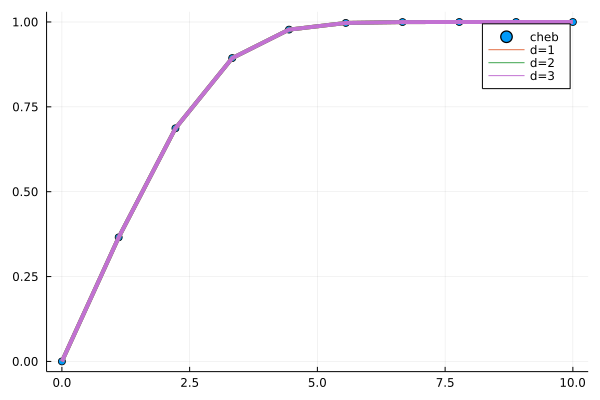

In [86]:
scatter(η, f_η.(x), label="cheb")
plot!(η, [t->u_lin(t), t->u_quad(t), t->u_spline(t)], label=["d=1" "d=2" "d=3"])

In [87]:
xx = LinRange(0, 10, 400)
norm(u_lin.(xx) - u_quad.(xx)), norm(u_quad.(xx) - u_spline.(xx)),  norm(u_lin.(xx) - u_spline.(xx))

(0.11305053626128458, 0.005755723996620085, 0.11476333092132981)

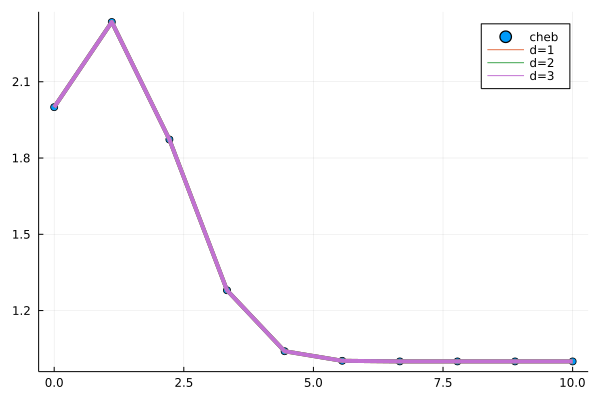

In [88]:
scatter(η, h.(x), label="cheb")
plot!(η, [t->T_lin(t), t->T_quad(t), t->T_spline(t)], label=["d=1" "d=2" "d=3"])

In [89]:
norm(T_lin.(xx) - T_quad.(xx)), norm(T_quad.(xx) - T_spline.(xx)),  norm(T_lin.(xx) - T_spline.(xx))

(0.5367577163517785, 0.07797201618642474, 0.579653625470396)

In [91]:
# Transverse velocity
v = (η .* f_η .- f) / 2; # v * √ (x / ν U)

In [93]:
plot(η, v.(x))

LoadError: MethodError: objects of type Vector{ChebyshevT{Float64, :x}} are not callable
Use square brackets [] for indexing an Array.